In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
from google.colab import drive
from IPython.display import Audio
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import IPython.display as ipd
import random
import soundfile as sf
# To play audio files in Jupyter notebooks
from IPython.display import Audio

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,TensorDataset
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

 Using device: cuda


In [ ]:
# List uploaded files
print(os.listdir('/content'))


['.config', 'drive', 'sample_data']


In [ ]:
drive_path = "/content/drive/My Drive"
files = os.listdir(drive_path)
print(files)


['ratings (1).csv', 'movies (1).csv', '20210802_221626.jpg', '20210802_221007.jpg', 'passport photo .jpg', 'Classroom', 'Books (2).csv', 'Ratings (1).csv', 'Users (2).csv', 'Colab Notebooks', 'my pic (2).jpg', 'my pic (1).jpg', 'my pic.jpg', 'Copy of CV_class_1.ipynb', '00.SurvivalAnalysis.pdf', '00.SurvivalAnalysis.gdoc', 'Screenshot_20250131-135752_GPay.jpg', 'students.gsheet', 'Sign.jpg', '006-Avirup Das-bonafide.pdf', 'Mycv (3).pdf', 'Mycv (2).pdf', 'Datasets', 'msc_1st_sem.pdf', 'NOC-IIIT KP -Avirup.pdf', 'autoencoders-slides_out.pdf', 'Avirup_template.zip', 'All_result_merged.pdf', 'id card.pdf', 'AADHAR Card.pdf', 'HS Certificate.pdf', 'Graduation Marksheet.pdf', 'Bank Passbook.pdf', 'falguni.jpg', 'Mycv .pdf', 'Mycv (1).pdf', 'AE_assignment (AvirupDas_B2430041) (1).ipynb', 'AE_assignment (AvirupDas_B2430041).ipynb', 'Speech_Emotion_Recognition', 'Books (1).csv.zip', 'Ratings (1).csv.zip', 'Users (1).csv.zip', 'Mycv.pdf', 'Stereo_Disparity.pdf', 'CamScaner.pdf', 'Disparity_Map.i

In [ ]:
drive_path = "/content/drive/My Drive/Datasets"
files = os.listdir(drive_path)
print(files)  # Check if 'ravdess.zip' is listed


['ravdess.zip', 'savee.zip', 'CREMA-D.zip', 'mfcc_data.npy', 'emotionsRnn.csv', 'mfcc_2d.npy', 'emotions.csv', 'mfcc_features.csv', 'augmented_data.csv']


## Whenever you restart Colab, just mount Drive and extract:

In [ ]:
# Path to dataset
zip_path = "/content/drive/My Drive/Datasets/ravdess.zip"
extract_path = "/content/ravdess"

# Extract
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" ravdess dataset is extracted successfully!")


 ravdess dataset is extracted successfully!


In [ ]:
extract_path = "/content/ravdess"  # Where to extract
print(os.listdir(extract_path))


['Actor_10', 'Actor_14', 'Actor_11', 'Actor_17', 'Actor_22', 'Actor_08', 'Actor_07', 'Actor_01', 'Actor_24', 'audio_speech_actors_01-24', 'Actor_21', 'Actor_06', 'Actor_18', 'Actor_12', 'Actor_05', 'Actor_15', 'Actor_03', 'Actor_13', 'Actor_23', 'Actor_20', 'Actor_16', 'Actor_04', 'Actor_19', 'Actor_02', 'Actor_09']


In [ ]:
# Check the extracted folders
for root, dirs, files in os.walk(extract_path):
    print(root, len(files))


/content/ravdess 0
/content/ravdess/Actor_10 60
/content/ravdess/Actor_14 60
/content/ravdess/Actor_11 60
/content/ravdess/Actor_17 60
/content/ravdess/Actor_22 60
/content/ravdess/Actor_08 60
/content/ravdess/Actor_07 60
/content/ravdess/Actor_01 60
/content/ravdess/Actor_24 60
/content/ravdess/audio_speech_actors_01-24 0
/content/ravdess/audio_speech_actors_01-24/Actor_10 60
/content/ravdess/audio_speech_actors_01-24/Actor_14 60
/content/ravdess/audio_speech_actors_01-24/Actor_11 60
/content/ravdess/audio_speech_actors_01-24/Actor_17 60
/content/ravdess/audio_speech_actors_01-24/Actor_22 60
/content/ravdess/audio_speech_actors_01-24/Actor_08 60
/content/ravdess/audio_speech_actors_01-24/Actor_07 60
/content/ravdess/audio_speech_actors_01-24/Actor_01 60
/content/ravdess/audio_speech_actors_01-24/Actor_24 60
/content/ravdess/audio_speech_actors_01-24/Actor_21 60
/content/ravdess/audio_speech_actors_01-24/Actor_06 60
/content/ravdess/audio_speech_actors_01-24/Actor_18 60
/content/ravdes

In [ ]:
ravdess_directory_list = os.listdir(extract_path)

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor_path = os.path.join(extract_path, dir)

    if os.path.isdir(actor_path):  # Ensure it's a directory
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Only process WAV files
                part = file.split('.')[0].split('-')
                file_emotion.append(int(part[2]))  # Extract emotion label
                file_path.append(os.path.join(actor_path, file))  # Full path

# Create DataFrame
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Convert integer emotions to labels
Ravdess_df.Emotions.replace({
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry',
    6: 'fear', 7: 'disgust', 8: 'surprise'
}, inplace=True)

print(Ravdess_df.head())


   Emotions                                               Path
0  surprise  /content/ravdess/Actor_10/03-01-08-02-01-02-10...
1   disgust  /content/ravdess/Actor_10/03-01-07-01-01-02-10...
2      fear  /content/ravdess/Actor_10/03-01-06-01-01-02-10...
3       sad  /content/ravdess/Actor_10/03-01-04-02-01-01-10...
4   neutral  /content/ravdess/Actor_10/03-01-01-01-02-01-10...


<ipython-input-10-693ea376784d>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({


In [ ]:
sample_audio = Ravdess_df.Path.iloc[0]  # First audio file
Audio(sample_audio)


In [ ]:
print(Ravdess_df.shape)  # Check the number of rows and columns
print(Ravdess_df.head())  # Display the first few rows


(1440, 2)
  Emotions                                               Path
0     calm  /content/ravdess/Actor_19/03-01-02-02-02-01-19...
1      sad  /content/ravdess/Actor_19/03-01-04-01-02-01-19...
2    angry  /content/ravdess/Actor_19/03-01-05-02-02-01-19...
3  neutral  /content/ravdess/Actor_19/03-01-01-01-02-01-19...
4  neutral  /content/ravdess/Actor_19/03-01-01-01-01-01-19...


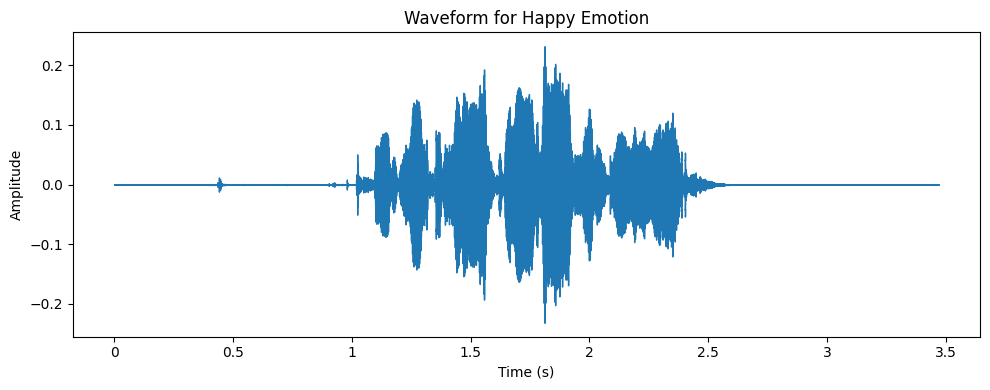

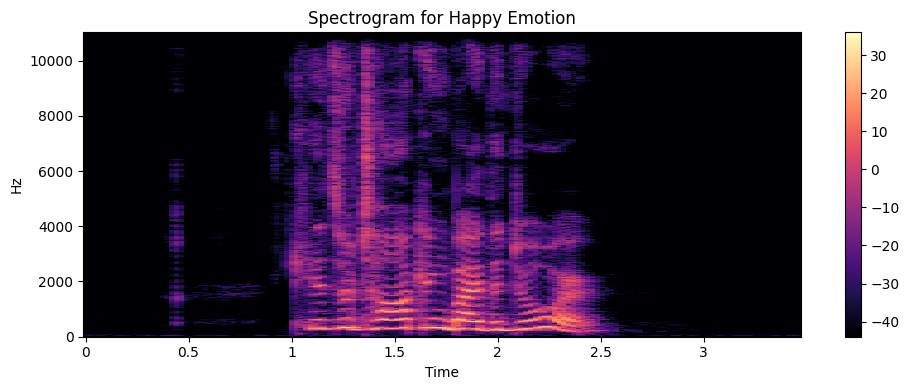

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Utility: Create Waveplot
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sr)
    plt.title(f"Waveform for {emotion} Emotion")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Utility: Create Spectrogram
def create_spectrogram(data, sr, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(f"Spectrogram for {emotion} Emotion")
    plt.tight_layout()
    plt.show()

# Select a file from "happy" emotion
happy_audio = Ravdess_df[Ravdess_df['Emotions'] == "happy"].iloc[0]["Path"]

# Load audio file
data, sr = librosa.load(happy_audio)

# Plot Waveform and Spectrogram
create_waveplot(data, sr, "Happy")
create_spectrogram(data, sr, "Happy")

# Play audio
Audio(happy_audio)


<ipython-input-12-19cebe09a0e5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=Ravdess_df['Emotions'], palette='viridis')


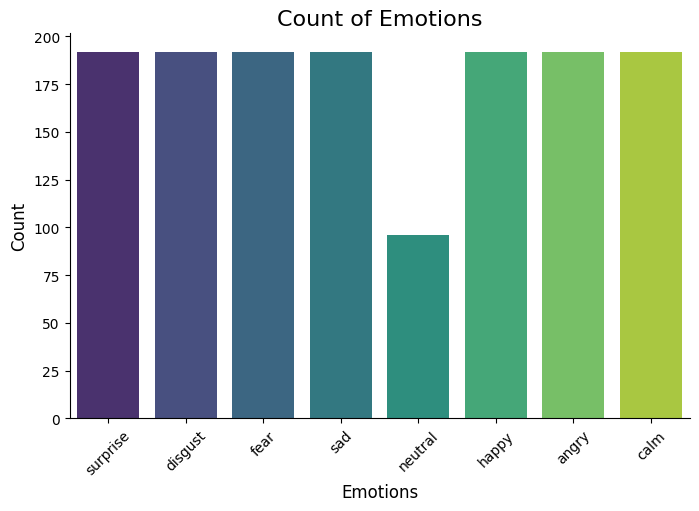

In [ ]:
# Check if the DataFrame is empty
if Ravdess_df.empty:
    print(" Error: The dataset is empty. Cannot plot emotion counts.")
else:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=Ravdess_df['Emotions'], palette='viridis')

    plt.title('Count of Emotions', fontsize=16)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('Emotions', fontsize=12)

    # Remove unnecessary borders
    sns.despine(top=True, right=True)

    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.show()


## Savee


In [ ]:
# Path to dataset
zip_path = "/content/drive/My Drive/Datasets/savee.zip"
extract_path = "/content/savee"

# Extract
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" savee dataset is extracted successfully!")


 savee dataset is extracted successfully!


In [ ]:
# Check the extracted folders
for root, dirs, files in os.walk(extract_path):
    print(root, len(files))


/content/savee 0
/content/savee/ALL 480


In [ ]:
# Define paths
zip_path = "/content/drive/My Drive/savee.zip"  # Update if needed
extract_path = "/content/savee"

# Extract ZIP file
if not os.path.exists(extract_path):  # Extract only if not already done
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print(" savee dataset extracted successfully!")

#  Check if files exist
print("Files in extracted directory:", os.listdir(extract_path))

# Emotion mapping based on filename prefixes
emotion_map = {
    'a': 'angry',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happy',
    'n': 'neutral',
    'sa': 'sad',
    'su': 'surprise'
}

# Lists to store file paths and corresponding emotions
file_emotion = []
file_path = []

# Iterate through all files
for folder in os.listdir(extract_path):  # The dataset may have subfolders
    folder_path = os.path.join(extract_path, folder)

    if os.path.isdir(folder_path):  # Ensure it's a directory
        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                parts = file.split('_')
                #print(parts)
                if len(parts) > 0:  # Ensure there's an emotion prefix
                    pattern = r'\d+'  # Split on digits
                    result = re.split(pattern, parts[1])
                    #print(result)
                    prefix = result[0]
                    if prefix in emotion_map:
                        file_emotion.append(emotion_map[prefix])
                        file_path.append(os.path.join(folder_path, file))

#  Create DataFrame
SAVEE_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

#  Verify the DataFrame
print("savee Dataset Loaded: ", SAVEE_df.shape)
SAVEE_df.head()

#  Play a sample audio
if not SAVEE_df.empty:
    sample_audio_path = SAVEE_df.iloc[0]['Path']
    display(Audio(sample_audio_path))
else:
    print(" Error: No audio files found!")


 savee dataset extracted successfully!
Files in extracted directory: ['ALL']
savee Dataset Loaded:  (480, 2)


In [ ]:
print(SAVEE_df.shape)  # Check the number of rows and columns
print(SAVEE_df.head())  # Display the first few rows|


(480, 2)
  Emotions                            Path
0  neutral   /content/savee/ALL/KL_n09.wav
1  neutral   /content/savee/ALL/JE_n01.wav
2      sad  /content/savee/ALL/JK_sa10.wav
3     fear   /content/savee/ALL/KL_f14.wav
4  neutral   /content/savee/ALL/KL_n27.wav


<ipython-input-17-f1facafdae48>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=SAVEE_df['Emotions'], palette='viridis')


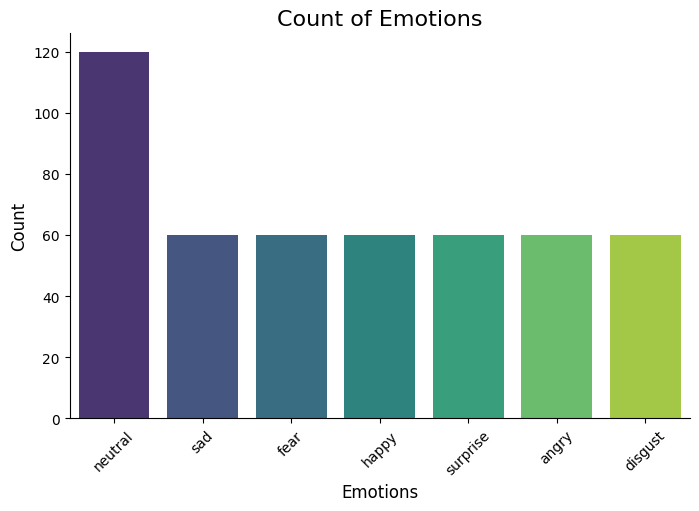

In [ ]:
# Check if the DataFrame is empty
if SAVEE_df.empty:
    print(" Error: The dataset is empty. Cannot plot emotion counts.")
else:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=SAVEE_df['Emotions'], palette='viridis')

    plt.title('Count of Emotions', fontsize=16)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('Emotions', fontsize=12)

    # Remove unnecessary borders
    sns.despine(top=True, right=True)

    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.show()


## CREMA-D

In [ ]:
# Path to dataset
zip_path = "/content/drive/My Drive/Datasets/CREMA-D.zip"
extract_path = "/content/CREMA-D"

# Extract
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" CREMA-D dataset is extracted successfully!")


 CREMA-D dataset is extracted successfully!


In [ ]:
# Check the extracted folders
for root, dirs, files in os.walk(extract_path):
    print(root, len(files))


/content/CREMA-D 0
/content/CREMA-D/AudioWAV 7442


In [ ]:
#  Set the correct dataset path
Crema = "/content/CREMA-D/AudioWAV/"
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

#  Extract emotions and file paths
for file in crema_directory_list:
    file_path.append(os.path.join(Crema, file))  # Correct file path handling
    part = file.split('_')

    # Emotion Mapping
    emotion_map = {
        "SAD": "sad", "ANG": "angry", "DIS": "disgust",
        "FEA": "fear", "HAP": "happy", "NEU": "neutral"
    }
    emotion = emotion_map.get(part[2], "Unknown")
    file_emotion.append(emotion)

#  Create DataFrame
Crema_df = pd.DataFrame({'Emotions': file_emotion,'Path': file_path})

#  Display sample rows
print(Crema_df.head())


  Emotions                                           Path
0  neutral  /content/CREMA-D/AudioWAV/1066_DFA_NEU_XX.wav
1     fear  /content/CREMA-D/AudioWAV/1046_ITS_FEA_XX.wav
2  neutral  /content/CREMA-D/AudioWAV/1012_IWW_NEU_XX.wav
3     fear  /content/CREMA-D/AudioWAV/1016_TIE_FEA_XX.wav
4  disgust  /content/CREMA-D/AudioWAV/1014_IWL_DIS_XX.wav


In [ ]:
#  Select a random file
sample_path = Crema_df['Path'].sample(1).values[0]

#  Load the audio file
y, sr = librosa.load(sample_path, sr=None)

#  Play the audio
ipd.Audio(y, rate=sr)


<ipython-input-21-0697e406c2eb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=Crema_df['Emotions'], palette='viridis', order=Crema_df['Emotions'].value_counts().index)


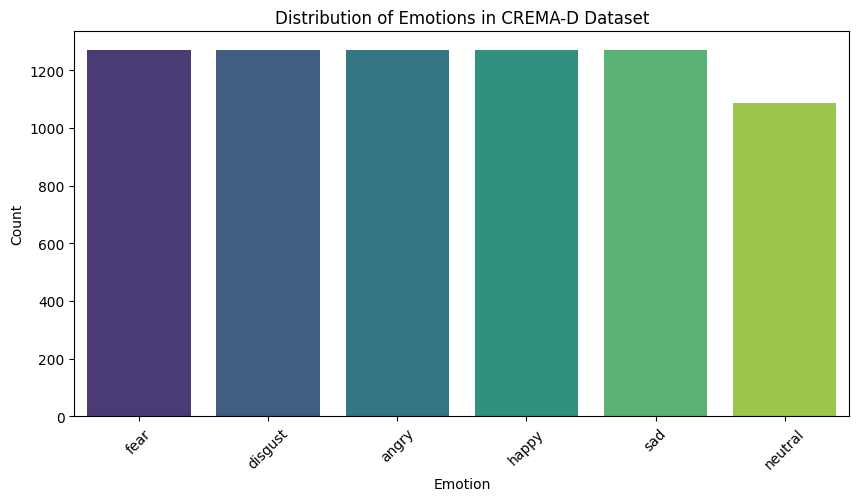

In [ ]:
#  Countplot for emotion distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=Crema_df['Emotions'], palette='viridis', order=Crema_df['Emotions'].value_counts().index)
plt.title("Distribution of Emotions in CREMA-D Dataset")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Combine all four datasets into one DataFrame
data_path = pd.concat([Crema_df, SAVEE_df, Ravdess_df], axis=0)

# Save to CSV
data_path.to_csv("data_path.csv", index=False)

# Display first few rows
data_path.head()


Emotions                                           Path
0  neutral  /content/CREMA-D/AudioWAV/1066_DFA_NEU_XX.wav
1     fear  /content/CREMA-D/AudioWAV/1046_ITS_FEA_XX.wav
2  neutral  /content/CREMA-D/AudioWAV/1012_IWW_NEU_XX.wav
3     fear  /content/CREMA-D/AudioWAV/1016_TIE_FEA_XX.wav
4  disgust  /content/CREMA-D/AudioWAV/1014_IWL_DIS_XX.wav

<ipython-input-23-defb891c712b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_path, x="Emotions", palette="viridis")  # "viridis" gives distinct colors


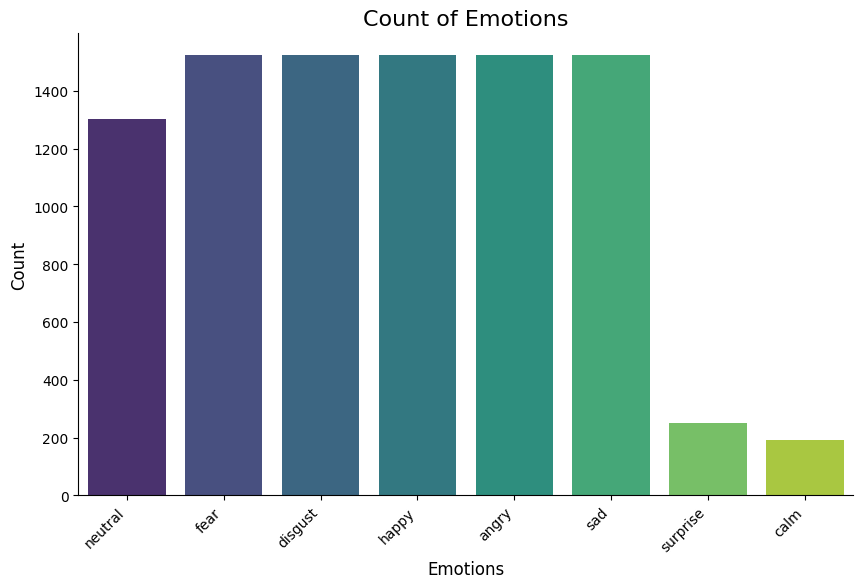

In [ ]:
# Set figure size
plt.figure(figsize=(10, 6))

# Create a vertical bar plot with different colors
sns.countplot(data=data_path, x="Emotions", palette="viridis")  # "viridis" gives distinct colors

# Customize labels and title
plt.title('Count of Emotions', size=16)
plt.xlabel('Emotions', size=12)
plt.ylabel('Count', size=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Remove unnecessary borders
sns.despine(top=True, right=True, left=False, bottom=False)

# Show the plot
plt.show()


## Data Augmentation


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")
 # Augmentation functions
def noise(y):
    noise_amp = 0.035 * np.random.uniform() * np.amax(y)
    return y + noise_amp * np.random.normal(size=y.shape[0])

def stretch(y, rate=0.8):
    return librosa.effects.time_stretch(y, rate=0.8)  #  FIXED function

def shift(y):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(y, shift_range)

def pitch(y, sr, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=pitch_factor)  #  FIXED function

# Function to apply augmentation to minority classes
def augment_audio(file_path, emotion):
    y, sr = librosa.load(file_path, sr=None)

    if emotion in ['surprise', 'calm']:  # Apply augmentation only to minority classes
        if random.choice([True, False]):
            y = noise(y)
        if random.choice([True, False]):
            y = stretch(y)  #  FIXED function call
        if random.choice([True, False]):
            y = pitch(y, sr, pitch_factor=2)  #  FIXED function call
        if random.choice([True, False]):
            y = shift(y)

    return y, sr

# Load the dataset
data_path = pd.read_csv("data_path.csv")

# Count occurrences of each emotion
emotion_counts = data_path["Emotions"].value_counts()
max_samples = emotion_counts.max()  # Maximum class count

augmented_data = []

# Create a directory to save augmented files
augmented_dir = "/content/augmented_data"
os.makedirs(augmented_dir, exist_ok=True)

# Apply augmentation to balance classes
for emotion, count in emotion_counts.items():
    emotion_df = data_path[data_path["Emotions"] == emotion]

    if count < max_samples:  # Only augment minority classes
        num_augments = max_samples - count  # How many more samples needed?

        for i in range(num_augments):
            sample = emotion_df.sample(n=1, replace=True).iloc[0]
            file_path = sample["Path"]

            y_aug, sr = augment_audio(file_path, emotion)

            # Save the augmented sample with a new filename
            new_filename = f"aug_{i}_{os.path.basename(file_path)}"
            new_filepath = os.path.join(augmented_dir, new_filename)

            # Save the augmented audio using soundfile
            sf.write(new_filepath, y_aug, sr)

            # Append new sample info to the dataset
            augmented_data.append([new_filepath, emotion])

# Convert augmented data into DataFrame
augmented_df = pd.DataFrame(augmented_data, columns=["Path", "Emotions"])

# Combine original and augmented datasets
balanced_data = pd.concat([data_path, augmented_df], ignore_index=True)

# Save the final dataset
balanced_data.to_csv("augmented_data.csv", index=False)

print(" Augmented data created and saved as 'augmented_data.csv'")


 Using device: cuda
 Augmented data created and saved as 'augmented_data.csv'


In [ ]:
import shutil
import os

# Define destination folder
destination_folder = "/content/drive/My Drive/Datasets"
os.makedirs(destination_folder, exist_ok=True)

# Copy the CSV file to Drive
shutil.copy("augmented_data.csv", os.path.join(destination_folder, "augmented_data.csv"))

print(" File saved to Google Drive!")


 File saved to Google Drive!


<ipython-input-27-98f63bd8b47a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=augmented_data, x="Emotions", palette="viridis")  # "viridis" gives distinct colors


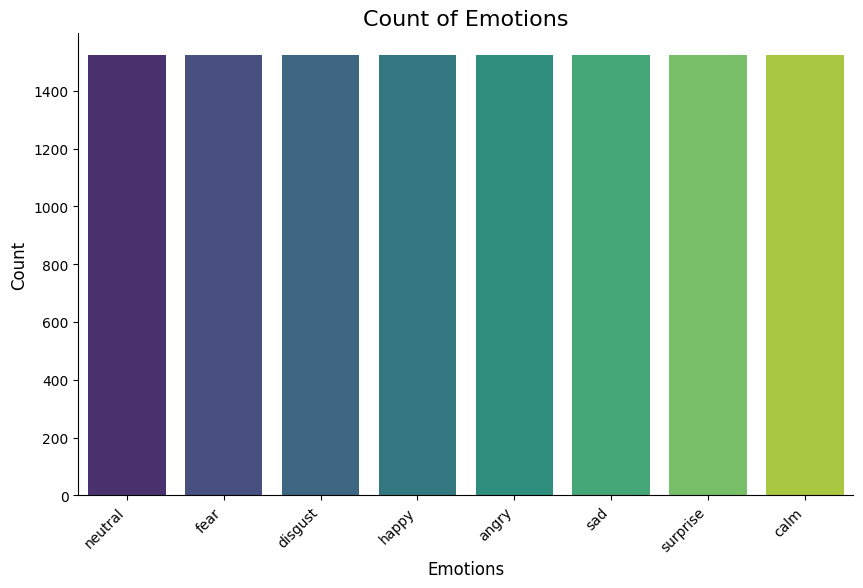

In [ ]:
augmented_data = pd.read_csv("/content/drive/My Drive/Datasets/augmented_data.csv")
# Set figure size
plt.figure(figsize=(10, 6))

# Create a vertical bar plot with different colors
sns.countplot(data=augmented_data, x="Emotions", palette="viridis")  # "viridis" gives distinct colors

# Customize labels and title
plt.title('Count of Emotions', size=16)
plt.xlabel('Emotions', size=12)
plt.ylabel('Count', size=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Remove unnecessary borders
sns.despine(top=True, right=True, left=False, bottom=False)

# Show the plot
plt.show()


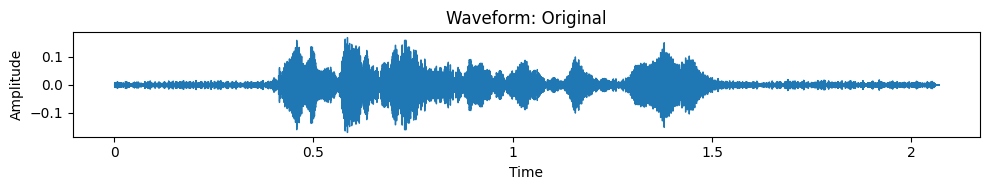

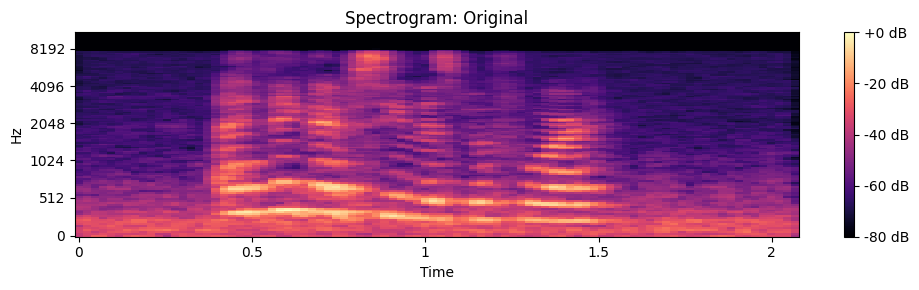

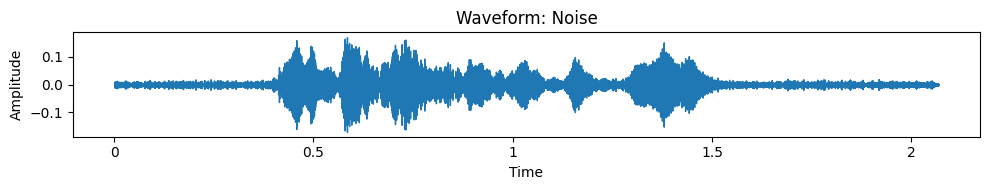

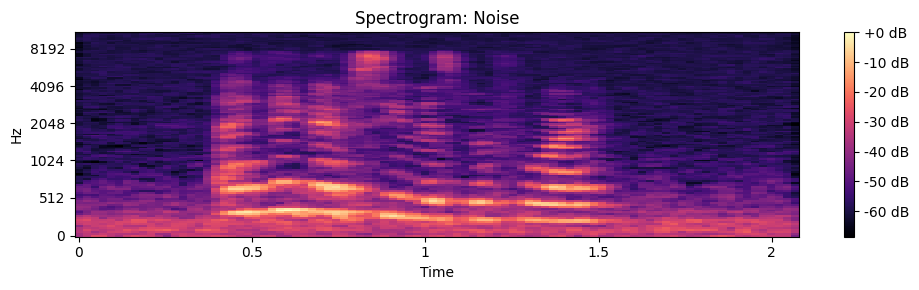

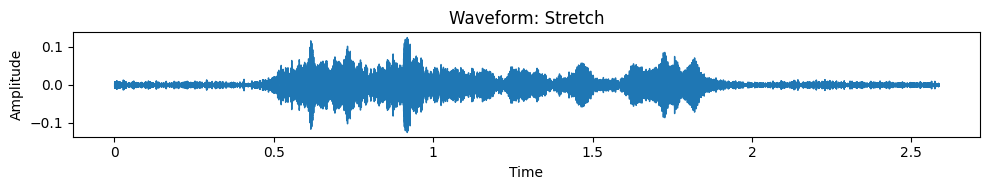

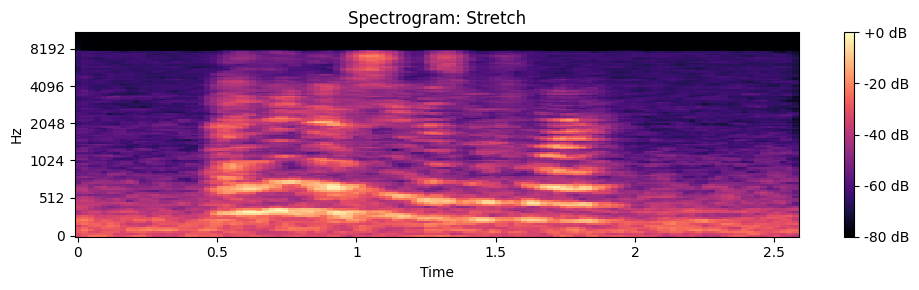

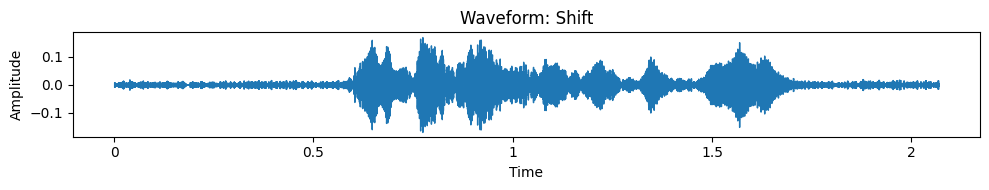

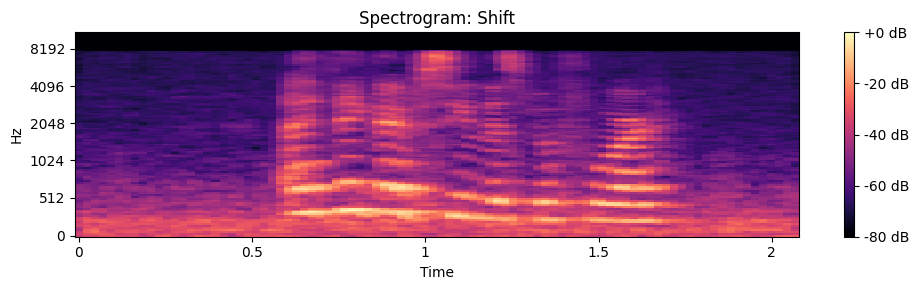

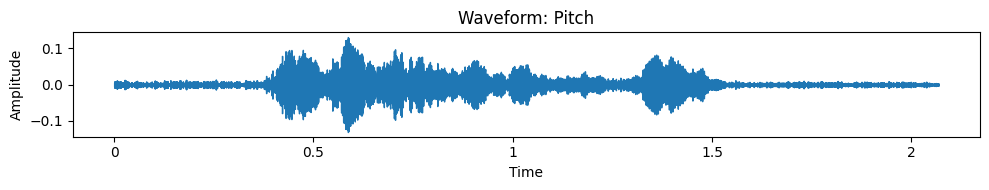

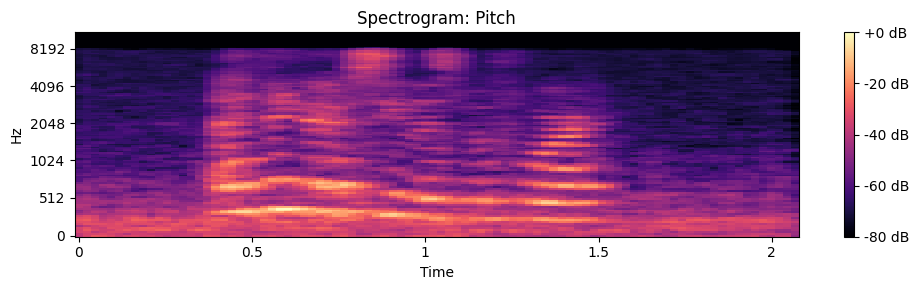

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

# Augmentation functions
def noise(y):
    noise_amp = 0.035 * np.random.uniform() * np.amax(y)
    return y + noise_amp * np.random.normal(size=y.shape[0])

def stretch(y, rate=0.8):
    return librosa.effects.time_stretch(y, rate=rate)

def shift(y):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(y, shift_range)

def pitch(y, sr, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=pitch_factor)

# Plotting helpers
def plot_waveform(y, sr, title):
    plt.figure(figsize=(10, 2))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {title}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def plot_spectrogram(y, sr, title):
    plt.figure(figsize=(10, 3))
    spect = librosa.feature.melspectrogram(y=y, sr=sr)
    spect_db = librosa.power_to_db(spect, ref=np.max)
    librosa.display.specshow(spect_db, sr=sr, x_axis='time', y_axis='mel')
    plt.title(f"Spectrogram: {title}")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Load sample audio
path = np.array(data_path.Path)[1]
y, sr = librosa.load(path)

# Apply augmentations
augmented_data = {
    "Original": y,
    "Noise": noise(y),
    "Stretch": stretch(y),
    "Shift": shift(y),
    "Pitch": pitch(y, sr)
}

# Plot vertically
for title, signal in augmented_data.items():
    plot_waveform(signal, sr, title)
    plot_spectrogram(signal, sr, title)

# Play original audio
Audio(path)


In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # Short-Time Fourier Transform (STFT)
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))

    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()


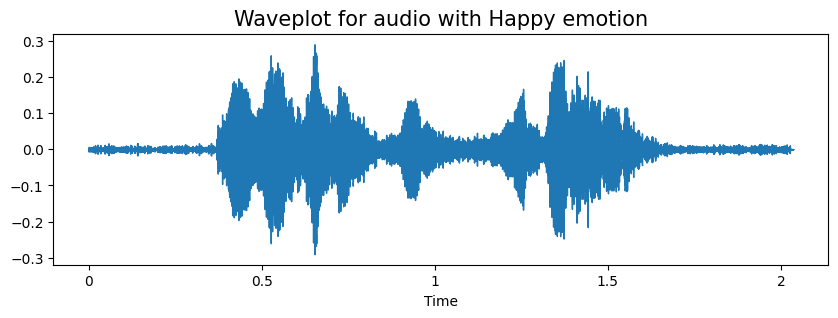

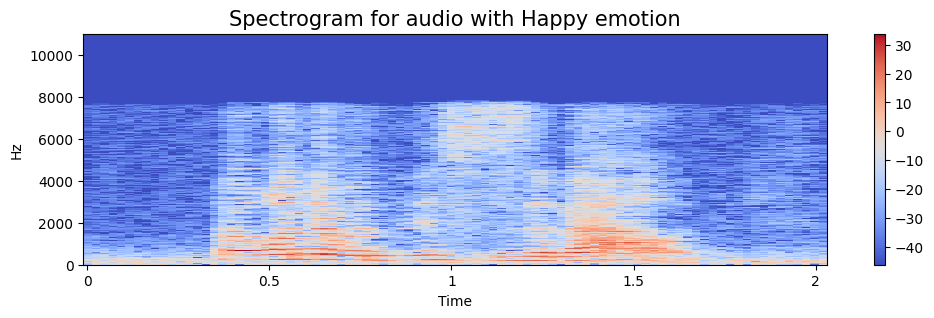

In [ ]:
# Filter "Happy" emotion
happy_audio = data_path[data_path["Emotions"] == "happy"].iloc[0]["Path"]
data, sr = librosa.load(happy_audio)

# Plot for Happy Emotion
create_waveplot(data, sr, "Happy")
create_spectrogram(data, sr, "Happy")
Audio(happy_audio)

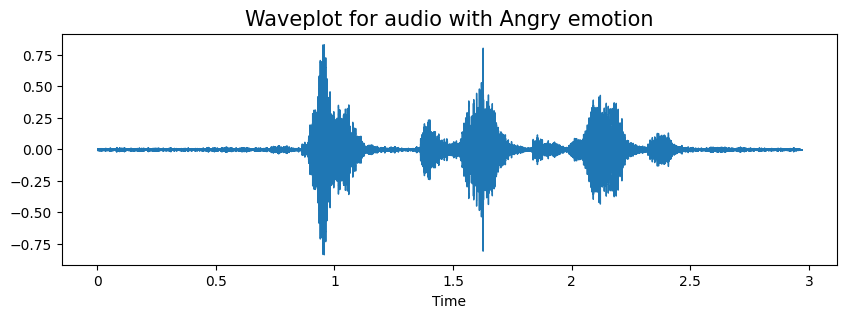

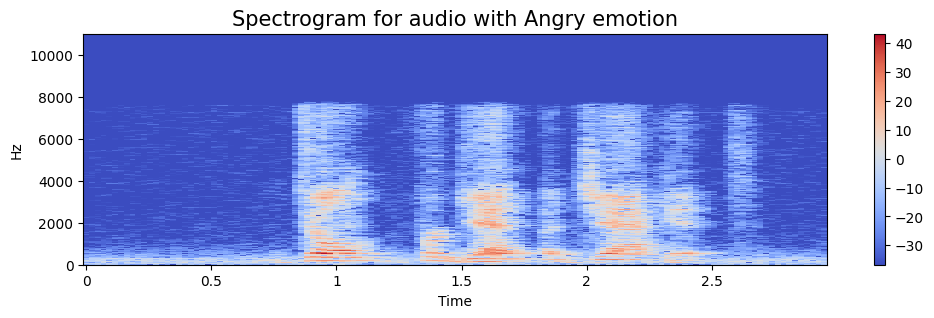

In [ ]:
# Filter "Angry" emotion
angry_audio = data_path[data_path["Emotions"] == "angry"].iloc[0]["Path"]
data, sr = librosa.load(angry_audio)
# Plot for Angry Emotion
create_waveplot(data, sr, "Angry")
create_spectrogram(data, sr, "Angry")
Audio(angry_audio)

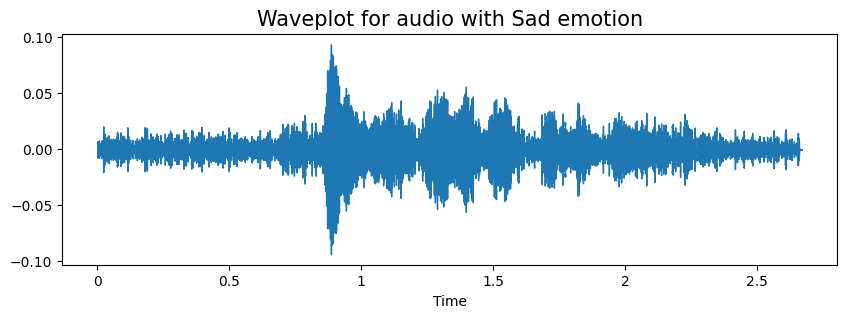

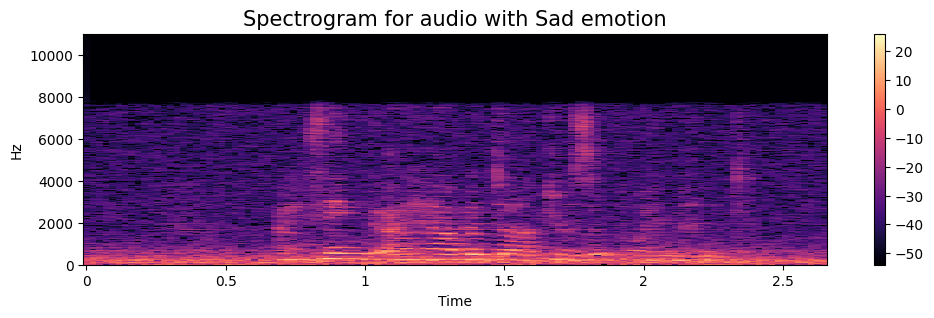

In [ ]:
# Filter "Sad" emotion
sad_audio = data_path[data_path["Emotions"] == "sad"].iloc[0]["Path"]
data, sr = librosa.load(sad_audio)

# Plot for Sad Emotion
create_waveplot(data, sr, "Sad")
create_spectrogram(data, sr, "Sad")
Audio(sad_audio)

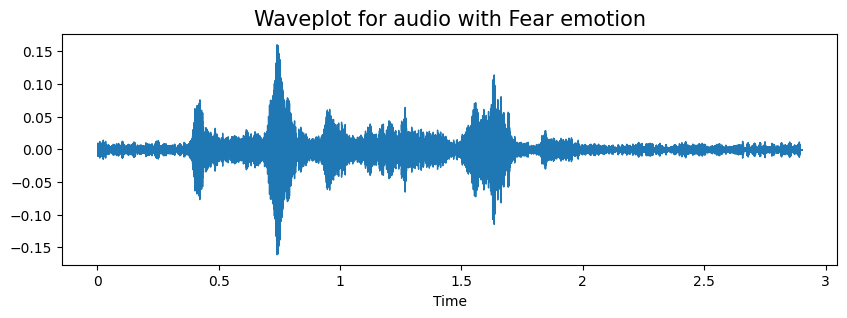

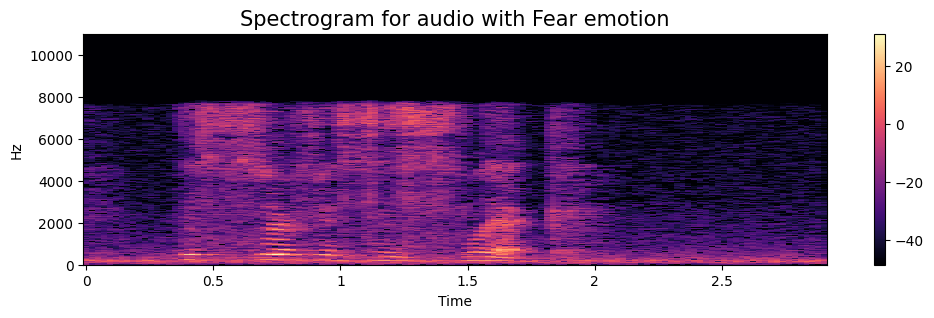

In [ ]:
# Filter "Fear" emotion
fear_audio = data_path[data_path["Emotions"] == "fear"].iloc[0]["Path"]
data, sr = librosa.load(fear_audio)

# Plot for Fear Emotion
create_waveplot(data, sr, "Fear")
create_spectrogram(data, sr, "Fear")
Audio(fear_audio)

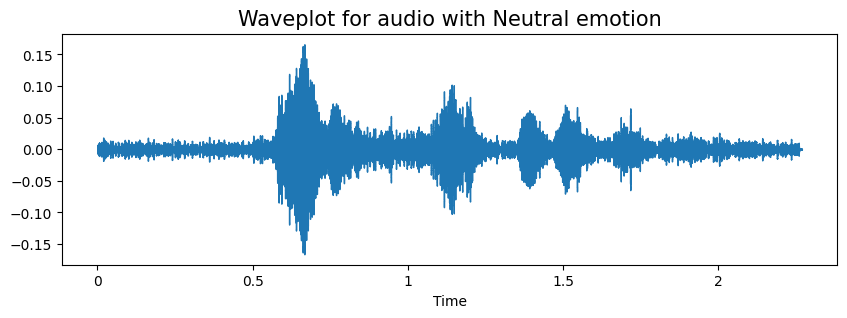

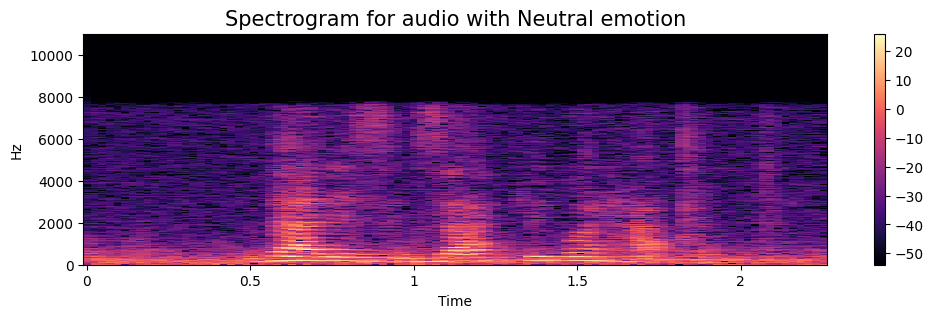

In [ ]:
# Filter "Neutral" emotion
neutral_audio = data_path[data_path["Emotions"] == "neutral"].iloc[0]["Path"]
data, sr = librosa.load(neutral_audio)

# Plot for Neutral Emotion
create_waveplot(data, sr, "Neutral")
create_spectrogram(data, sr, "Neutral")
Audio(neutral_audio)

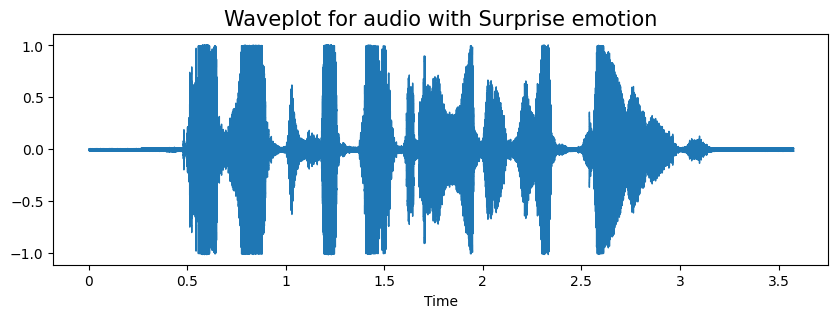

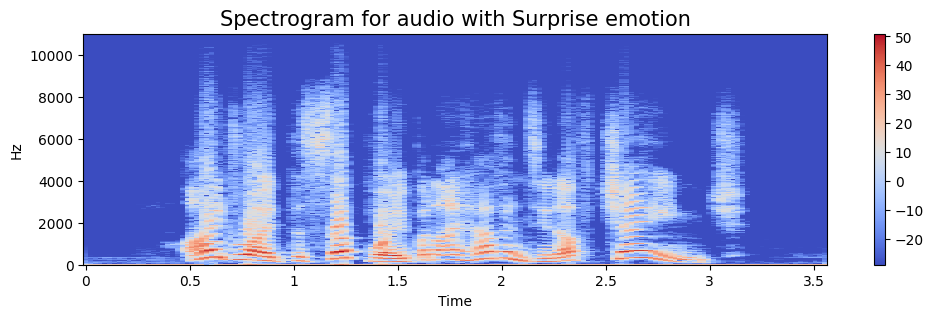

In [ ]:
# Filter "Surprise" emotion
surprise_audio = data_path[data_path["Emotions"] == "surprise"].iloc[0]["Path"]
data, sr = librosa.load(surprise_audio)

# Plot for Surprise Emotion
create_waveplot(data, sr, "Surprise")
create_spectrogram(data, sr, "Surprise")
Audio(surprise_audio)

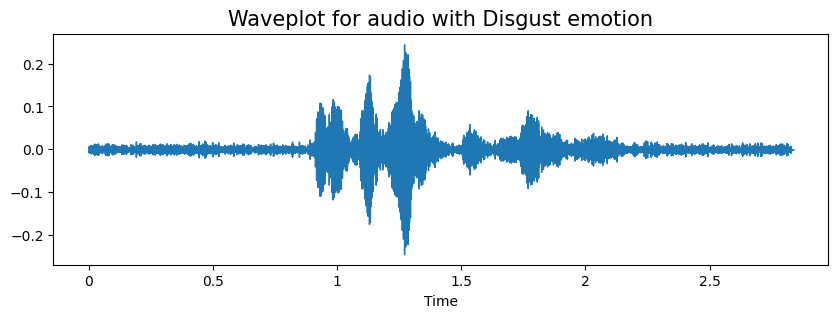

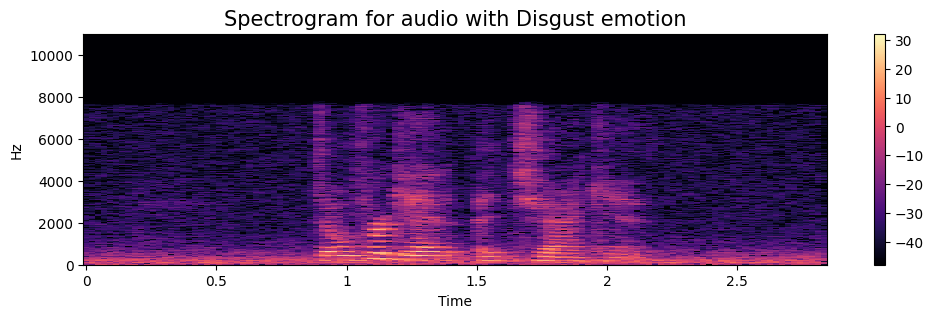

In [ ]:
# Filter "Disgust" emotion
disgust_audio = data_path[data_path["Emotions"] == "disgust"].iloc[0]["Path"]
data, sr = librosa.load(disgust_audio)

# Plot for Disgust Emotion
create_waveplot(data, sr, "Disgust")
create_spectrogram(data, sr, "Disgust")
Audio(disgust_audio)

### Function to Extract MFCCs



In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch

# # Step 1: Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Step 2: Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

# Step 3: Load the augmented dataset
df = pd.read_csv("/content/drive/My Drive/Datasets/augmented_data.csv")  # Adjust if needed

# Step 4: Function to extract MFCC features
def extract_mfcc_features(audio_path, n_mfcc=40):
    y, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

# Step 5: Extract MFCC features
mfcc_features = np.array([extract_mfcc_features(path) for path in df['Path']])
df_mfcc = pd.DataFrame(mfcc_features)
df_mfcc["Emotions"] = df["Emotions"]

# Step 6: Save extracted features to Google Drive
save_path = "/content/drive/My Drive/Datasets/mfcc_features.csv"
df_mfcc.to_csv(save_path, index=False)
print(f" MFCC features saved to: {save_path}")

# Step 7: Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Emotions"])

# Step 8: Normalize MFCC features
scaler = StandardScaler()
X = scaler.fit_transform(mfcc_features)

# Step 9: Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 10% val, 10% test

# Step 10: Convert to PyTorch tensors and move to device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

print(" Data split into Train (80%), Validation (10%), and Test (10%)!")
print(f" Data moved to {device} for model training!")



Using device: cpu
Extracting MFCC features...
MFCC features saved to: /content/drive/My Drive/Datasets/mfcc_features.csv
Data split into Train (80%), Validation (10%), and Test (10%)
Data moved to cpu for model training


In [ ]:
df_mfcc = pd.read_csv("/content/drive/My Drive/Datasets/mfcc_features.csv")

# 3. Separate features and labels
X = df_mfcc.drop("Emotions", axis=1).values
y = df_mfcc["Emotions"].values

# 4. Encode the emotion labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 5. Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 6. Split into Train, Validation, Test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 7. Move to PyTorch tensors and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

print(" MFCC features loaded, encoded, and ready for model training!")

 MFCC features loaded, encoded, and ready for model training!


### Define MLP Model

In [ ]:
# Define a more complex MLP model with BatchNorm and Dropout
class ImprovedMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Increased neurons
        self.bn1 = nn.BatchNorm1d(256)  # Batch Normalization
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # Dropout for regularization

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(64, num_classes)  # Output layer

    def forward(self, x):
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x  # No Softmax since CrossEntropyLoss includes it


Using device: cuda
 Best model saved!
Epoch [1/30] | Train Loss: 1.6133 | Train Acc: 38.13% | Val Loss: 1.3206 | Val Acc: 46.31%
 Best model saved!
Epoch [2/30] | Train Loss: 1.3693 | Train Acc: 46.96% | Val Loss: 1.2581 | Val Acc: 50.08%
 Best model saved!
Epoch [3/30] | Train Loss: 1.3028 | Train Acc: 49.72% | Val Loss: 1.2094 | Val Acc: 50.57%
 Best model saved!
Epoch [4/30] | Train Loss: 1.2598 | Train Acc: 51.43% | Val Loss: 1.1716 | Val Acc: 53.12%
 Best model saved!
Epoch [5/30] | Train Loss: 1.2380 | Train Acc: 52.56% | Val Loss: 1.1509 | Val Acc: 53.28%
 Best model saved!
Epoch [6/30] | Train Loss: 1.2059 | Train Acc: 53.46% | Val Loss: 1.1166 | Val Acc: 53.94%
Epoch [7/30] | Train Loss: 1.1912 | Train Acc: 54.03% | Val Loss: 1.1258 | Val Acc: 53.86%
 Best model saved!
Epoch [8/30] | Train Loss: 1.1752 | Train Acc: 54.44% | Val Loss: 1.1228 | Val Acc: 55.01%
Epoch [9/30] | Train Loss: 1.1590 | Train Acc: 55.89% | Val Loss: 1.1010 | Val Acc: 54.68%
 Best model saved!
Epoch [10/

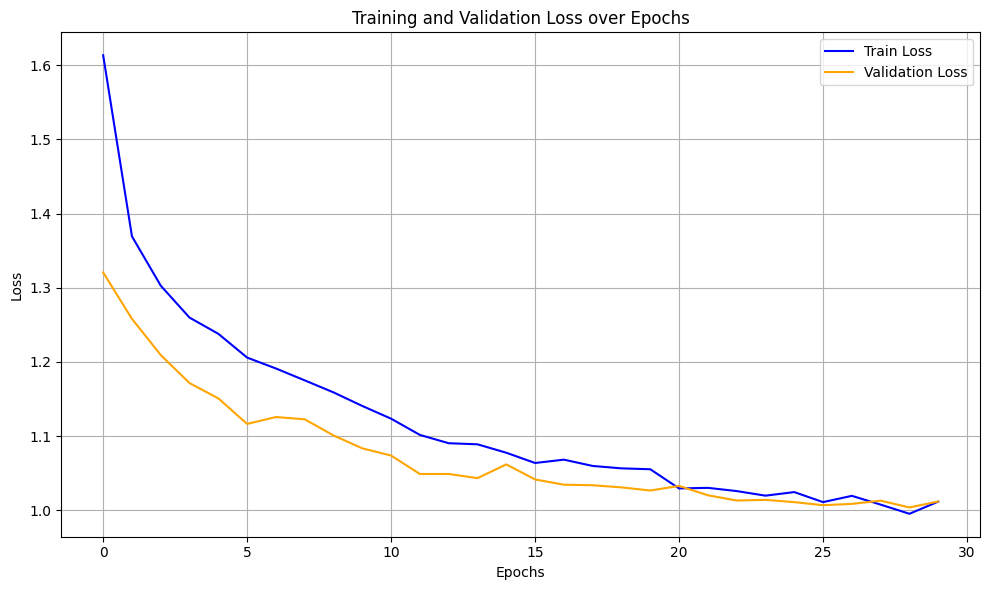

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#  Set device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#  Create TensorDataset for train, validation, and test sets
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#  Initialize model
input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)
model = ImprovedMLP(input_size, num_classes).to(device)

#  Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)  # AdamW with weight decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Reduce LR every 10 epochs
train_losses = []
val_losses = []

#  Training Loop with Validation
num_epochs = 30
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    #  Validation Phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    #  Save Best Model to Google Drive
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/drive/My Drive/Speech_Emotion_Recognition/best_model.pth")
        print(" Best model saved!")

    #  Print Epoch Results
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    #  Adjust Learning Rate
    scheduler.step()

print(" Training Complete! Best Validation Accuracy:", best_val_acc)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.4 MB/s eta 0:00:00


In [ ]:
import optuna

def objective(trial):
    # Define the search space
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    dropout_rate = trial.suggest_uniform("dropout", 0.1, 0.5)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    activation = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])
    optimizer_type = trial.suggest_categorical("optimizer", ["Adam", "RMSProp", "SGD","Adadelta"])

    # Define the model with trial parameters
    class TunedMLP(nn.Module):
        def __init__(self, input_size, num_classes):
            super(TunedMLP, self).__init__()
            self.fc1 = nn.Linear(input_size, 256)
            self.bn1 = nn.BatchNorm1d(256)
            self.activation1 = nn.ReLU() if activation == "ReLU" else nn.LeakyReLU()
            self.dropout1 = nn.Dropout(dropout_rate)

            self.fc2 = nn.Linear(256, 128)
            self.bn2 = nn.BatchNorm1d(128)
            self.activation2 = nn.ReLU() if activation == "ReLU" else nn.LeakyReLU()
            self.dropout2 = nn.Dropout(dropout_rate)

            self.fc3 = nn.Linear(128, 64)
            self.activation3 = nn.ReLU() if activation == "ReLU" else nn.LeakyReLU()
            self.dropout3 = nn.Dropout(dropout_rate)

            self.fc4 = nn.Linear(64, num_classes)

        def forward(self, x):
            x = self.dropout1(self.activation1(self.bn1(self.fc1(x))))
            x = self.dropout2(self.activation2(self.bn2(self.fc2(x))))
            x = self.dropout3(self.activation3(self.fc3(x)))
            x = self.fc4(x)
            return x

    # Load data
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    model = TunedMLP(input_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train for a few epochs
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validate the model
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    return val_accuracy

# Run hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2025-04-30 20:59:40,976] A new study created in memory with name: no-name-cbf84701-d7e7-4656-8445-aa0fe9059c74
<ipython-input-38-8d1ee4798887>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
<ipython-input-38-8d1ee4798887>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-38-8d1ee4798887>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
[W 2

NameError: name 'X_train' is not defined

In [ ]:
import optuna

# Best hyperparameters from Optuna
best_params = {'lr':0.0006441338858817185, 'batch_size': 32, 'dropout': 0.10159535985028201, 'weight_decay': 2.176464682171428e-06, 'activation': 'ReLU', 'optimizer': 'Adam'}

# Define the final model with best hyperparameters
class FinalMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FinalMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.activation1 = nn.LeakyReLU() if best_params['activation'] == 'LeakyReLU' else nn.ReLU()
        self.dropout1 = nn.Dropout(best_params['dropout'])

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.activation2 = nn.LeakyReLU() if best_params['activation'] == 'LeakyReLU' else nn.ReLU()
        self.dropout2 = nn.Dropout(best_params['dropout'])

        self.fc3 = nn.Linear(128, 64)
        self.activation3 = nn.LeakyReLU() if best_params['activation'] == 'LeakyReLU' else nn.ReLU()
        self.dropout3 = nn.Dropout(best_params['dropout'])

        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.dropout1(self.activation1(self.bn1(self.fc1(x))))
        x = self.dropout2(self.activation2(self.bn2(self.fc2(x))))
        x = self.dropout3(self.activation3(self.fc3(x)))
        x = self.fc4(x)
        return x



In [ ]:
# Load data
full_train_dataset = TensorDataset(torch.cat([X_train, X_val]), torch.cat([y_train, y_val]))
full_train_loader = DataLoader(full_train_dataset, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=best_params['batch_size'], shuffle=False)

model = FinalMLP(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()

if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
else:
    optimizer = optim.SGD(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

# Train final model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for features, labels in full_train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(full_train_loader):.4f}, Accuracy: {train_acc:.2f}%")



Epoch [1/50], Loss: 1.5012, Accuracy: 42.89%
Epoch [2/50], Loss: 1.2668, Accuracy: 51.19%
Epoch [3/50], Loss: 1.2036, Accuracy: 53.58%
Epoch [4/50], Loss: 1.1449, Accuracy: 56.01%
Epoch [5/50], Loss: 1.1085, Accuracy: 57.75%
Epoch [6/50], Loss: 1.0797, Accuracy: 58.67%
Epoch [7/50], Loss: 1.0488, Accuracy: 59.36%
Epoch [8/50], Loss: 1.0299, Accuracy: 59.83%
Epoch [9/50], Loss: 0.9971, Accuracy: 61.61%
Epoch [10/50], Loss: 0.9796, Accuracy: 62.36%
Epoch [11/50], Loss: 0.9722, Accuracy: 62.88%
Epoch [12/50], Loss: 0.9455, Accuracy: 63.86%
Epoch [13/50], Loss: 0.9397, Accuracy: 64.35%
Epoch [14/50], Loss: 0.9179, Accuracy: 64.87%
Epoch [15/50], Loss: 0.9002, Accuracy: 65.54%
Epoch [16/50], Loss: 0.9032, Accuracy: 65.60%
Epoch [17/50], Loss: 0.8830, Accuracy: 66.02%
Epoch [18/50], Loss: 0.8690, Accuracy: 66.88%
Epoch [19/50], Loss: 0.8539, Accuracy: 67.63%
Epoch [20/50], Loss: 0.8406, Accuracy: 67.48%
Epoch [21/50], Loss: 0.8390, Accuracy: 67.67%
Epoch [22/50], Loss: 0.8325, Accuracy: 67.8

In [ ]:
# Evaluate on test set
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 61.85%


<Figure size 800x600 with 0 Axes>

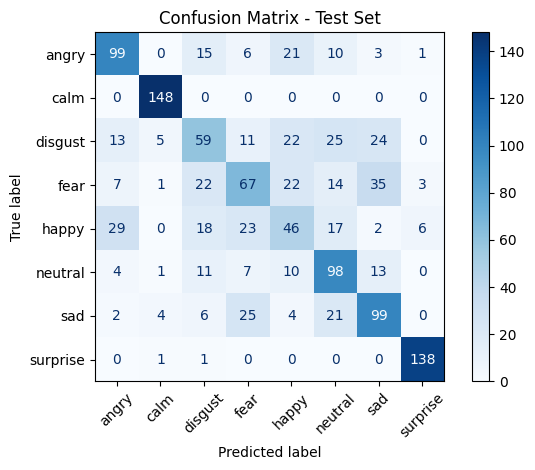


Classification Metrics:
Accuracy:  0.6185
Precision: 0.6065
Recall:    0.6185
F1 Score:  0.6097

Detailed Classification Report:
              precision    recall  f1-score   support

       angry       0.64      0.64      0.64       155
        calm       0.93      1.00      0.96       148
     disgust       0.45      0.37      0.41       159
        fear       0.48      0.39      0.43       171
       happy       0.37      0.33      0.35       141
     neutral       0.53      0.68      0.60       144
         sad       0.56      0.61      0.59       161
    surprise       0.93      0.99      0.96       140

    accuracy                           0.62      1219
   macro avg       0.61      0.63      0.62      1219
weighted avg       0.61      0.62      0.61      1219



In [ ]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import numpy as np

# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optional: class labels
class_names = label_encoder.classes_

# Display confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

# Compute and print classification metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print("\nClassification Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Full classification report per class
print("Detailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))


# CNN

In [ ]:
import librosa
import numpy as np
import pandas as pd
import os
# Instead of old df, load this:
df = pd.read_csv("augmented_data.csv")

# Step 1: Define MFCC extraction function
def extract_mfcc_2d(audio_path, n_mfcc=40, max_len=100):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Pad or truncate to max_len frames
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc  # shape: (n_mfcc, max_len)

# Step 2: Load your DataFrame (assume df has columns: ['Path', 'Emotions'])
# Example: df = pd.read_csv("your_audio_paths_and_labels.csv")

# Step 3: Extract MFCC features while skipping missing files
mfcc_features = []
emotions_kept = []

for idx, path in enumerate(df['Path']):
    if os.path.exists(path):
        mfcc = extract_mfcc_2d(path)
        mfcc_features.append(mfcc)
        emotions_kept.append(df['Emotions'][idx])
    else:
        print(f" Skipping missing file: {path}")

# Step 4: Convert to array and add channel dimension
mfcc_2d = np.array(mfcc_features)  # shape: (N, 40, 100)
mfcc_2d = mfcc_2d[:, np.newaxis, :, :]  # shape: (N, 1, 40, 100)

# Step 5: Create a clean DataFrame for emotions
df_clean = pd.DataFrame({"Emotions": emotions_kept})

# Step 6: Save extracted features and labels
save_folder = "/content/drive/My Drive/Datasets/"
os.makedirs(save_folder, exist_ok=True)

# Save MFCC features as .npy
np.save(os.path.join(save_folder, "mfcc_2d.npy"), mfcc_2d)

# Save Emotions as .csv
df_clean.to_csv(os.path.join(save_folder, "emotions.csv"), index=False)

print(f" MFCC features saved to: {os.path.join(save_folder, 'mfcc_2d.npy')}")
print(f" Emotions saved to: {os.path.join(save_folder, 'emotions.csv')}")



 MFCC features saved to: /content/drive/My Drive/Datasets/mfcc_2d.npy
 Emotions saved to: /content/drive/My Drive/Datasets/emotions.csv


In [ ]:
# Load MFCC features
mfcc_2d = np.load("/content/drive/My Drive/Datasets/mfcc_2d.npy")

# Load Emotions
emotions = pd.read_csv("/content/drive/My Drive/Datasets/emotions.csv")

print(mfcc_2d.shape)  # Should be (N, 1, 40, 100)
print(emotions.head())


(12184, 1, 40, 100)
  Emotions
0  neutral
1     fear
2  neutral
3     fear
4  disgust


In [ ]:
import os

# List files in the folder
print(os.listdir("/content/augmented_data/"))


['aug_56_1008_ITH_NEU_XX.wav', 'aug_639_JK_su13.wav', 'aug_556_03-01-02-02-02-02-24.wav', 'aug_1236_03-01-02-02-02-02-19.wav', 'aug_421_03-01-02-01-01-02-19.wav', 'aug_761_JK_su01.wav', 'aug_301_03-01-08-02-02-02-14.wav', 'aug_684_03-01-08-01-02-02-23.wav', 'aug_891_03-01-08-02-01-02-18.wav', 'aug_945_03-01-08-01-02-01-20.wav', 'aug_1128_03-01-02-01-01-01-04.wav', 'aug_1222_03-01-02-01-02-01-14.wav', 'aug_837_JE_su06.wav', 'aug_129_1036_IEO_NEU_XX.wav', 'aug_1220_03-01-08-02-02-01-10.wav', 'aug_1033_JK_su01.wav', 'aug_584_03-01-08-01-02-01-02.wav', 'aug_77_DC_su10.wav', 'aug_53_03-01-02-02-02-01-20.wav', 'aug_995_03-01-08-02-02-02-14.wav', 'aug_532_03-01-08-02-01-01-01.wav', 'aug_156_1064_IOM_NEU_XX.wav', 'aug_853_03-01-08-02-01-01-11.wav', 'aug_812_03-01-02-02-01-02-14.wav', 'aug_795_03-01-02-01-02-02-23.wav', 'aug_834_03-01-08-01-01-02-17.wav', 'aug_1152_03-01-02-01-02-01-16.wav', 'aug_650_03-01-02-02-01-01-12.wav', 'aug_644_03-01-08-02-01-01-23.wav', 'aug_620_KL_su10.wav', 'aug_403_

In [ ]:
from sklearn.preprocessing import LabelEncoder
import torch

# Initialize and fit the label encoder
label_encoder = LabelEncoder()
label_encoder.fit(df["Emotions"])  # Fit the encoder on the labels

# Now transform the labels
y = torch.tensor(label_encoder.transform(df["Emotions"]), dtype=torch.long)
X = torch.tensor(mfcc_2d, dtype=torch.float32)


In [ ]:
# Split the data into 80% training and 20% (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y)

# Now split the 20% into 50% validation and 50% test, which results in 10% val and 10% test of the original data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

# Send to GPU
X_train, X_val, X_test = X_train.to(device), X_val.to(device), X_test.to(device)
y_train, y_val, y_test = y_train.to(device), y_val.to(device), y_test.to(device)


In [ ]:
import torch
import torch.nn as nn

class SpeechEmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(SpeechEmotionCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (1, 40, 100) -> (32, 40, 100)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),  # -> (32, 20, 50)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # -> (64, 20, 50)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),  # -> (64, 10, 25)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # -> (128, 10, 25)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),  # -> (128, 5, 12)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # -> (128*5*12 = 7680)
            nn.Linear(128 * 5 * 12, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


In [ ]:
model = SpeechEmotionCNN(num_classes=len(label_encoder.classes_)).to(device)


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import copy

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler (Reduce LR when validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Early stopping params
patience = 10
best_val_acc = 0
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_counter = 0

num_epochs = 50

for epoch in range(1, num_epochs + 1):
    # Training phase
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Print epoch stats
    print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Step the scheduler
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    # Early stopping
    if early_stop_counter >= patience:
        print(f" Early stopping at epoch {epoch}")
        break

# Load best model weights
model.load_state_dict(best_model_wts)

print(f"\n Training complete! Best Val Acc: {best_val_acc:.2f}%")


Epoch [1/50], Train Loss: 1.7424, Train Acc: 33.32%, Val Loss: 1.4180, Val Acc: 46.06%
Epoch [2/50], Train Loss: 1.4257, Train Acc: 42.82%, Val Loss: 1.3276, Val Acc: 48.77%
Epoch [3/50], Train Loss: 1.3627, Train Acc: 46.36%, Val Loss: 1.2791, Val Acc: 48.85%
Epoch [4/50], Train Loss: 1.3276, Train Acc: 48.05%, Val Loss: 1.2557, Val Acc: 48.36%
Epoch [5/50], Train Loss: 1.2798, Train Acc: 50.03%, Val Loss: 1.2269, Val Acc: 50.25%
Epoch [6/50], Train Loss: 1.2465, Train Acc: 50.94%, Val Loss: 1.1562, Val Acc: 54.11%
Epoch [7/50], Train Loss: 1.2265, Train Acc: 52.06%, Val Loss: 1.2070, Val Acc: 50.41%
Epoch [8/50], Train Loss: 1.1922, Train Acc: 53.72%, Val Loss: 1.1846, Val Acc: 52.63%
Epoch [9/50], Train Loss: 1.1865, Train Acc: 52.92%, Val Loss: 1.1750, Val Acc: 54.02%
Epoch [10/50], Train Loss: 1.1461, Train Acc: 55.20%, Val Loss: 1.1685, Val Acc: 53.20%
Epoch [11/50], Train Loss: 1.1286, Train Acc: 56.06%, Val Loss: 1.1321, Val Acc: 56.57%
Epoch [12/50], Train Loss: 1.0961, Train 

In [ ]:
# Evaluate on Test Set
model.eval()
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64)

test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_acc = 100 * test_correct / test_total
print(f" Test Accuracy: {test_acc:.2f}%")


 Test Accuracy: 64.56%


<Figure size 800x600 with 0 Axes>

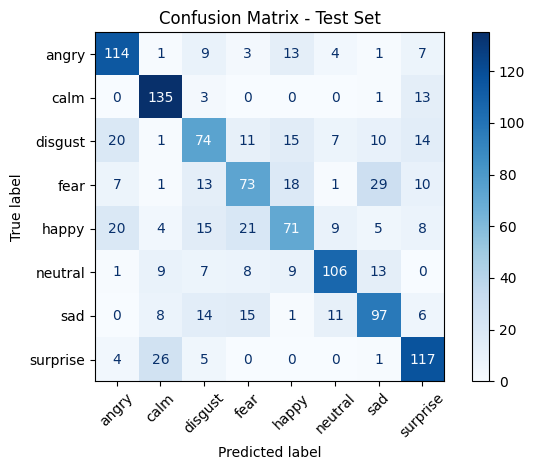


Classification Metrics:
Accuracy:  0.6456
Precision: 0.6395
Recall:    0.6456
F1 Score:  0.6398

Detailed Classification Report:
              precision    recall  f1-score   support

       angry       0.69      0.75      0.72       152
        calm       0.73      0.89      0.80       152
     disgust       0.53      0.49      0.51       152
        fear       0.56      0.48      0.52       152
       happy       0.56      0.46      0.51       153
     neutral       0.77      0.69      0.73       153
         sad       0.62      0.64      0.63       152
    surprise       0.67      0.76      0.71       153

    accuracy                           0.65      1219
   macro avg       0.64      0.65      0.64      1219
weighted avg       0.64      0.65      0.64      1219



In [ ]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import numpy as np

# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optional: class labels
class_names = label_encoder.classes_

# Display confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

# Compute and print classification metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print("\nClassification Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Full classification report per class
print("Detailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))


In [ ]:
# Split the data into 70% training and 30% (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y)

# Now split the 30% into 50% validation and 50% test, which results in 10% val and 20% test of the original data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

# Send to GPU
X_train, X_val, X_test = X_train.to(device), X_val.to(device), X_test.to(device)
y_train, y_val, y_test = y_train.to(device), y_val.to(device), y_test.to(device)


In [ ]:
import optuna
import torch.nn.functional as F

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout_feature = trial.suggest_float("dropout_feature", 0.2, 0.5)
    dropout_fc = trial.suggest_float("dropout_fc", 0.3, 0.6)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # Define model with dropout values from trial
    class TunedCNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout(dropout_feature)
            )
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(512 * 1 * 3, 256),
                nn.ReLU(),
                nn.Dropout(dropout_fc),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, len(label_encoder.classes_))
            )

        def forward(self, x):
            x = self.features(x)
            return self.classifier(x)

    model = TunedCNN().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    best_val_acc = 0
    for epoch in range(10):  # Small epoch to speed up trial
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best trial:", study.best_trial.params)


[I 2025-05-01 10:02:05,818] A new study created in memory with name: no-name-78331b12-4d95-4ae6-8963-f9d30c247c06
[I 2025-05-01 10:02:30,559] Trial 0 finished with value: 0.5853858784893268 and parameters: {'lr': 0.0013991611150730402, 'dropout_feature': 0.23292800276798578, 'dropout_fc': 0.39771653054352407, 'batch_size': 64, 'weight_decay': 1.8845894403582527e-06}. Best is trial 0 with value: 0.5853858784893268.
[I 2025-05-01 10:02:54,100] Trial 1 finished with value: 0.555008210180624 and parameters: {'lr': 2.6698536012233765e-05, 'dropout_feature': 0.352900901957788, 'dropout_fc': 0.4910550547559849, 'batch_size': 128, 'weight_decay': 0.00013190851965019502}. Best is trial 0 with value: 0.5853858784893268.
[I 2025-05-01 10:03:21,430] Trial 2 finished with value: 0.5862068965517241 and parameters: {'lr': 5.0281007536577856e-05, 'dropout_feature': 0.4460014834550032, 'dropout_fc': 0.5737968259226609, 'batch_size': 32, 'weight_decay': 0.000192259861218222}. Best is trial 2 with value:

Best trial: {'lr': 0.0009551696263829892, 'dropout_feature': 0.4204824656477956, 'dropout_fc': 0.3431686376540499, 'batch_size': 128, 'weight_decay': 1.5231769995806892e-05}


In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4204824656477956)  # ← Use Optuna's dropout_feature
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.3431686376540499),  # ← Use Optuna's dropout_fc
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [ ]:
model = ImprovedCNN(num_classes=len(label_encoder.classes_)).to(device)
import copy

# Define loss and optimizer with tuned params
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0009551696263829892, weight_decay=1.5231769995806892e-05)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# DataLoaders with tuned batch size
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

# Training loop with early stopping
patience = 10
best_val_acc = 0
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_counter = 0
num_epochs = 50

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f" Early stopping at epoch {epoch}")
        break

model.load_state_dict(best_model_wts)
print(f"\n Training complete! Best Val Acc: {best_val_acc:.2f}%")

Epoch [1/50], Train Loss: 1.5896, Train Acc: 36.41%, Val Loss: 1.4281, Val Acc: 44.66%
Epoch [2/50], Train Loss: 1.3273, Train Acc: 47.93%, Val Loss: 1.4177, Val Acc: 39.66%
Epoch [3/50], Train Loss: 1.2679, Train Acc: 50.38%, Val Loss: 1.3033, Val Acc: 48.44%
Epoch [4/50], Train Loss: 1.2047, Train Acc: 53.33%, Val Loss: 1.2575, Val Acc: 48.93%
Epoch [5/50], Train Loss: 1.1477, Train Acc: 56.18%, Val Loss: 1.1218, Val Acc: 57.06%
Epoch [6/50], Train Loss: 1.0904, Train Acc: 58.28%, Val Loss: 1.1523, Val Acc: 53.45%
Epoch [7/50], Train Loss: 1.0499, Train Acc: 60.12%, Val Loss: 1.3432, Val Acc: 50.08%
Epoch [8/50], Train Loss: 1.0120, Train Acc: 62.33%, Val Loss: 1.1420, Val Acc: 58.13%
Epoch [9/50], Train Loss: 0.9802, Train Acc: 63.41%, Val Loss: 1.1392, Val Acc: 57.06%
Epoch [10/50], Train Loss: 0.9069, Train Acc: 66.10%, Val Loss: 1.2129, Val Acc: 56.57%
Epoch [11/50], Train Loss: 0.8482, Train Acc: 68.69%, Val Loss: 1.1331, Val Acc: 57.47%
Epoch [12/50], Train Loss: 0.7324, Train 

In [ ]:
# Evaluate on Test Set
model.eval()
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128)

test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_acc = 100 * test_correct / test_total
print(f" Test Accuracy: {test_acc:.2f}%")


 Test Accuracy: 65.79%


<Figure size 800x600 with 0 Axes>

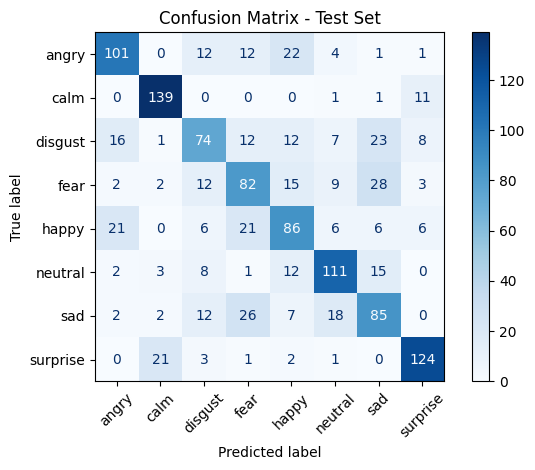


Classification Metrics:
Accuracy:  0.6579
Precision: 0.6554
Recall:    0.6579
F1 Score:  0.6556

Detailed Classification Report:
              precision    recall  f1-score   support

       angry       0.70      0.66      0.68       153
        calm       0.83      0.91      0.87       152
     disgust       0.58      0.48      0.53       153
        fear       0.53      0.54      0.53       153
       happy       0.55      0.57      0.56       152
     neutral       0.71      0.73      0.72       152
         sad       0.53      0.56      0.55       152
    surprise       0.81      0.82      0.81       152

    accuracy                           0.66      1219
   macro avg       0.66      0.66      0.66      1219
weighted avg       0.66      0.66      0.66      1219



In [ ]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import numpy as np

# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optional: class labels
class_names = label_encoder.classes_

# Display confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

# Compute and print classification metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print("\nClassification Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Full classification report per class
print("Detailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
